# Install Library

In [ ]:
!pip install googletrans
!pip install tensorflowjs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model
import matplotlib.pyplot as plt
from googletrans import Translator

# Load Data

In [ ]:
df_review = pd.read_csv('https://raw.githubusercontent.com/snapeat-bangkit/Machine-Learning/main/dataset/reviews.csv')
df_kategori = pd.read_csv('https://raw.githubusercontent.com/snapeat-bangkit/Machine-Learning/main/dataset/resto_categories.csv')

merged_df = pd.merge(df_review, df_kategori[['place_id', 'categories', 'link']], on='place_id', how='left')
merged_df = merged_df.drop(columns=['published_at', 'published_at_date', 'response_from_owner_text', 'response_from_owner_ago', 'response_from_owner_date', 'review_translated_text', 'response_from_owner_translated_text'])

merged_df['rating'] = df_review['rating'].astype(int)
merged_df['review_likes_count'] = df_review['review_likes_count'].astype(int)
merged_df['total_number_of_reviews_by_reviewer'] = df_review['total_number_of_reviews_by_reviewer'].astype(int)
merged_df['total_number_of_photos_by_reviewer'] = df_review['total_number_of_photos_by_reviewer'].astype(int)
merged_df['is_local_guide'] = df_review['is_local_guide'].astype(bool)

merged_df

,user_id,place_id,place_name,review_id,rating,review_text,review_likes_count,total_number_of_reviews_by_reviewer,total_number_of_photos_by_reviewer,is_local_guide,review_photos,categories,link
0,4,ChIJTwTtG9P1aS4RTBuC8A4MTBA,Paulaner Brauhaus,ChZDSUhNMG9nS0VJQ0FnSUQ5amRpMEhBEAE,5,"Banyak pilihan beer dikasih tester dulu 3 mcm,...",1,269,1347,True,"[""https://lh5.googleusercontent.com/p/AF1QipNx...","Restoran Jerman, Brewpub",https://www.google.com/maps/place/Paulaner+Br%...
1,21,ChIJTwTtG9P1aS4RTBuC8A4MTBA,Paulaner Brauhaus,ChZDSUhNMG9nS0VJQ0FnSUN6M3NMc1hnEAE,5,Nyaman deh tempatnya pelayananya juga memuaska...,0,8,7,False,"[""https://lh5.googleusercontent.com/p/AF1QipOM...","Restoran Jerman, Brewpub",https://www.google.com/maps/place/Paulaner+Br%...
2,1,ChIJTwTtG9P1aS4RTBuC8A4MTBA,Paulaner Brauhaus,ChdDSUhNMG9nS0VJQ0FnSUNkLUw2MHJRRRAB,5,Ini kedua kalinya datang kesini. Buat yang mau...,0,21,28,True,"[""https://lh5.googleusercontent.com/p/AF1QipO1...","Restoran Jerman, Brewpub",https://www.google.com/maps/place/Paulaner+Br%...
3,28,ChIJTwTtG9P1aS4RTBuC8A4MTBA,Paulaner Brauhaus,ChZDSUhNMG9nS0VJQ0FnSUNkLWNxb0JBEAE,5,Letak nya di GI east mall. Harga cukup mahal. ...,0,120,591,True,"[""https://lh5.googleusercontent.com/p/AF1QipOA...","Restoran Jerman, Brewpub",https://www.google.com/maps/place/Paulaner+Br%...
4,49,ChIJTwTtG9P1aS4RTBuC8A4MTBA,Paulaner Brauhaus,ChZDSUhNMG9nS0VJQ0FnSUMxMUtPSFh3EAE,4,Harga makanan di 100rb+\r\nMinuman di 50rbuan....,4,817,12396,True,"[""https://lh5.googleusercontent.com/p/AF1QipMP...","Restoran Jerman, Brewpub",https://www.google.com/maps/place/Paulaner+Br%...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,15,ChIJkayuSl31aS4RoCogGjqbz9g,The Courtyard Jakarta,ChdDSUhNMG9nS0VJQ0FnSUNseUlqVWtRRRAB,5,"Tempat yang unik dan nyaman skali, makanannya ...",0,7,0,False,[],Restoran,https://www.google.com/maps/place/The+Courtyar...
876,36,ChIJkayuSl31aS4RoCogGjqbz9g,The Courtyard Jakarta,ChZDSUhNMG9nS0VJQ0FnSUNscS1Td1VBEAE,5,Tempatnya bagus,0,6,4,True,[],Restoran,https://www.google.com/maps/place/The+Courtyar...
877,39,ChIJkayuSl31aS4RoCogGjqbz9g,The Courtyard Jakarta,ChdDSUhNMG9nS0VJQ0FnSUNpNGZ6UmhnRRAB,5,Wowww place in Jakarta... enakk banget meeting...,0,646,606,True,[],Restoran,https://www.google.com/maps/place/The+Courtyar...
878,33,ChIJkayuSl31aS4RoCogGjqbz9g,The Courtyard Jakarta,ChdDSUhNMG9nS0VJQ0FnSUQ1MnE3S3d3RRAB,5,Halamannya sejuk,0,3,2,False,[],Restoran,https://www.google.com/maps/place/The+Courtyar...


# Content-based Filtering

## Pre-processing

In [ ]:
def translate_text(text):
    translator = Translator()
    translated = translator.translate(text, src='id', dest='en')
    return translated.text

# Menerapkan terjemahan pada kolom 'review_text' jika diperlukan
merged_df['review_text_en'] = merged_df['review_text']
# Menerapkan terjemahan hanya untuk teks yang dalam bahasa Indonesia
indonesian_mask = merged_df['review_text_en'].str.contains(r'[^\x00-\x7F]+', na=False)
merged_df.loc[indonesian_mask, 'review_text_en'] = merged_df.loc[indonesian_mask, 'review_text_en'].apply(translate_text)


# Pra-pemrosesan data
restaurant_reviews = merged_df.groupby('place_id')['review_text_en'].apply(lambda x: ' '.join(x))
restaurant_scores = merged_df.groupby('place_id')['rating'].mean()

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(restaurant_reviews)

# Pisahkan data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, restaurant_scores.values, test_size=0.2, random_state=42)

# Konversi ke tensor dense
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

## Content-based Model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/350
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 21.1008 - root_mean_squared_error: 4.5926 - val_loss: 20.9511 - val_root_mean_squared_error: 4.5772
Epoch 2/350
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 21.5389 - root_mean_squared_error: 4.6409 - val_loss: 20.1586 - val_root_mean_squared_error: 4.4898
Epoch 3/350
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 22.2614 - root_mean_squared_error: 4.7181 - val_loss: 19.4038 - val_root_mean_squared_error: 4.4050
Epoch 4/350
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 19.3808 - root_mean_squared_error: 4.4020 - val_loss: 18.7321 - val_root_mean_squared_error: 4.3281
Epoch 5/350
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 20.3047 - root_mean_squared_error: 4.5060 - val_loss: 18.2044 - val_root_mean_squared_error: 4.2667
Epoch 6/350
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 20.6126 - root_mean_squared_error: 4.5394 - val_loss: 17.5905 - val_root_mean_squared_error: 4.1941
Epoch 7/350
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - l

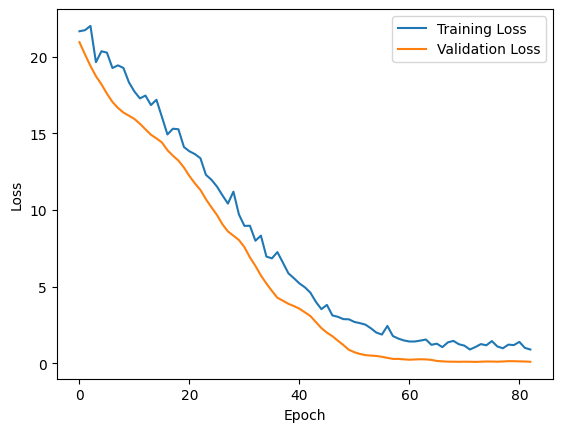

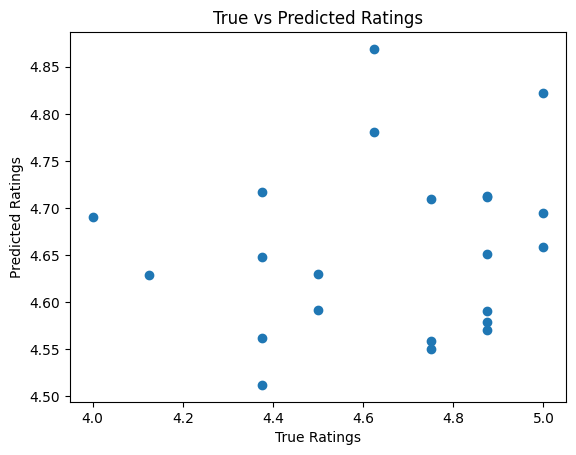

In [ ]:
# Build model with TensorFlow
class ContentModel(tf.keras.Model):
    def __init__(self, num_features):
        super(ContentModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu', input_shape=(None, num_features))
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.dropout1 = tf.keras.layers.Dropout(0.3)

        self.dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.dropout2 = tf.keras.layers.Dropout(0.3)

        self.dense3 = tf.keras.layers.Dense(128, activation='relu')
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.dropout3 = tf.keras.layers.Dropout(0.2)

        self.dense4 = tf.keras.layers.Dense(64, activation='relu')
        self.batch_norm4 = tf.keras.layers.BatchNormalization()
        self.dropout4 = tf.keras.layers.Dropout(0.2)

        self.dense5 = tf.keras.layers.Dense(32, activation='relu')
        self.batch_norm5 = tf.keras.layers.BatchNormalization()
        self.dropout5 = tf.keras.layers.Dropout(0.1)

        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x = self.dense2(x)
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        x = self.dense3(x)
        x = self.batch_norm3(x)
        x = self.dropout3(x)

        x = self.dense4(x)
        x = self.batch_norm4(x)
        x = self.dropout4(x)

        x = self.dense5(x)
        x = self.batch_norm5(x)
        x = self.dropout5(x)

        return self.output_layer(x)

# Inisialisasi model
num_features = X_train_dense.shape[1]
#model_content = ContentModel(num_features)

content_inputs = tf.keras.layers.Input(shape=(num_features, ))
#model_collab.build(input_shape=(None, 2))
#model_collab.summary()
content_outputs = ContentModel(num_features)(content_inputs)

model_content = tf.keras.Model(inputs=content_inputs, outputs=content_outputs)

# Kompilasi model
model_content.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model_content.fit(X_train_dense, y_train, epochs=350, batch_size=16, validation_data=(X_test_dense, y_test), callbacks=[early_stopping])

# Evaluasi model
y_pred = model_content.predict(X_test_dense).flatten()
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)

# Buat grafik loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Buat grafik
plt.scatter(y_test, y_pred)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs Predicted Ratings')
plt.show()

In [ ]:
model_content.build(input_shape=(num_features, ))
model_content.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 7061)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ content_model_1 (ContentModel)       │ (None, 1)                   │       3,794,305 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,378,949 (43.41 MB)

 Trainable params: 3,792,321 (14.47 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 7,584,644 (28.93 MB)

# Collaborative Filtering

## Pre-processing

In [ ]:
# Split data into training and testing sets
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

# Convert user_id and place_id to categorical data
user_ids = merged_df['user_id'].unique().tolist()
place_ids = merged_df['place_id'].unique().tolist()

user_id2idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
place_id2idx = {place_id: idx for idx, place_id in enumerate(place_ids)}

merged_df['user_id'] = merged_df['user_id'].map(user_id2idx)
merged_df['place_id'] = merged_df['place_id'].map(place_id2idx)

train_df['user_id'] = train_df['user_id'].map(user_id2idx)
train_df['place_id'] = train_df['place_id'].map(place_id2idx)

test_df['user_id'] = test_df['user_id'].map(user_id2idx)
test_df['place_id'] = test_df['place_id'].map(place_id2idx)

## Collaborative Model

In [ ]:
class CollabModel(tf.keras.Model):
    def __init__(self, num_users, num_places, embedding_size):
        super(CollabModel, self).__init__()
        self.user_embedding = tf.keras.layers.Embedding(input_dim=num_users, output_dim=embedding_size, embeddings_regularizer=tf.keras.regularizers.l2(1e-4))
        self.place_embedding = tf.keras.layers.Embedding(input_dim=num_places, output_dim=embedding_size, embeddings_regularizer=tf.keras.regularizers.l2(1e-4))
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(128, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(0.7)
        self.dense3 = tf.keras.layers.Dense(64, activation='relu')
        self.dropout3 = tf.keras.layers.Dropout(0.5)
        self.output_layer = tf.keras.layers.Dense(1, activation='linear')

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        place_vector = self.place_embedding(inputs[:, 1])
        x = tf.concat([user_vector, place_vector], axis=1)
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        x = self.dense3(x)
        x = self.dropout3(x)
        output = self.output_layer(x)
        return output

num_users = len(user_ids)
num_places = len(place_ids)
embedding_size = 20

collab_inputs = tf.keras.layers.Input(shape=(2,), dtype=tf.int32)
collab_outputs = CollabModel(num_users, num_places, embedding_size)(collab_inputs)

model_collab = tf.keras.Model(inputs=collab_inputs, outputs=collab_outputs)
model_collab.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7.5070 - root_mean_squared_error: 2.6507 - val_loss: 1.6894 - val_root_mean_squared_error: 1.2988
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5030 - root_mean_squared_error: 1.8698 - val_loss: 1.4879 - val_root_mean_squared_error: 1.2181
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4833 - root_mean_squared_error: 1.5708 - val_loss: 1.2700 - val_root_mean_squared_error: 1.1246
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4826 - root_mean_squared_error: 1.5722 - val_loss: 1.8054 - val_root_mean_squared_error: 1.3416
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5601 - root_mean_squared_error: 1.2456 - val_loss: 0.8922 - val_root_mean_squared_error: 0.9417
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2849 - root_mean_squared_error: 1.1302 - val_loss: 1.1306 - val_root_mean_squared_error: 1.0608
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

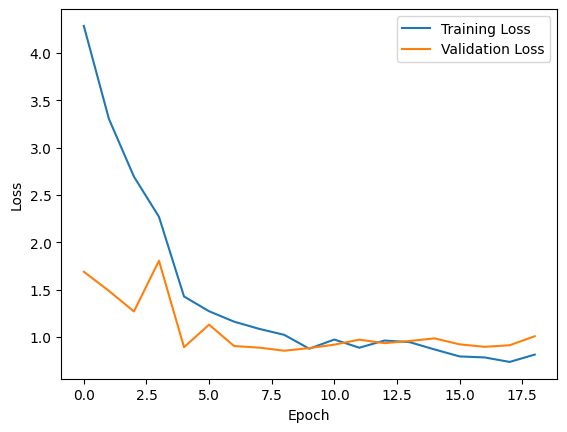

In [ ]:
train_data = train_df[['user_id', 'place_id']].values
train_labels = train_df['rating'].values

test_data = test_df[['user_id', 'place_id']].values
test_labels = test_df['rating'].values

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_collab.fit(
    x=train_data,
    y=train_labels,
    epochs=100,
    batch_size=8,
    verbose=1,
    validation_data=(test_data, test_labels),
    callbacks=[early_stopping]
)

# Evaluasi model
y_pred = model_collab.predict(test_data).flatten()
mse = mean_squared_error(test_labels, y_pred)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)

# Buat grafik loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model_collab.build(input_shape=(None, 2))
model_collab.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ collab_model (CollabModel)           │ (None, 1)                   │          54,913 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,741 (643.52 KB)

 Trainable params: 54,913 (214.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 109,828 (429.02 KB)

# Ensembling

## Pre-processing

In [ ]:
# Prepare data for hybrid model
user_ids = merged_df['user_id'].unique().tolist()
place_ids = merged_df['place_id'].unique().tolist()

user_id2idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
place_id2idx = {place_id: idx for idx, place_id in enumerate(place_ids)}

merged_df['user_id'] = merged_df['user_id'].map(user_id2idx)
merged_df['place_id'] = merged_df['place_id'].map(place_id2idx)

# Split data into training and testing sets for hybrid model
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

# Get TF-IDF vectors for train and test data
train_tfidf_matrix = tfidf_matrix[train_df['place_id'].map(place_id2idx).values]
test_tfidf_matrix = tfidf_matrix[test_df['place_id'].map(place_id2idx).values]

# Prepare hybrid model input data
train_data = np.concatenate([train_df[['user_id', 'place_id']].values, train_tfidf_matrix.toarray()], axis=1)
test_data = np.concatenate([test_df[['user_id', 'place_id']].values, test_tfidf_matrix.toarray()], axis=1)
train_labels = train_df['rating'].values
test_labels = test_df['rating'].values

# Normalize or standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_data[:, 2:] = scaler.fit_transform(train_data[:, 2:])
test_data[:, 2:] = scaler.transform(test_data[:, 2:])


## Hybrid Model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 240ms/step - loss: 13.1394 - root_mean_squared_error: 3.5509 - val_loss: 242.1732 - val_root_mean_squared_error: 15.5618
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7743 - root_mean_squared_error: 1.6626 - val_loss: 46.3569 - val_root_mean_squared_error: 6.8083
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6635 - root_mean_squared_error: 1.2880 - val_loss: 5.5242 - val_root_mean_squared_error: 2.3495
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3907 - root_mean_squared_error: 1.1773 - val_loss: 1.7027 - val_root_mean_squared_error: 1.3032
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1347 - root_mean_squared_error: 1.0626 - val_loss: 1.3365 - val_root_mean_squared_error: 1.1541
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1310 - root_mean_squared_error: 1.0605 - val_loss: 1.1281 - val_root_mean_squared_error: 1.0600
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
MSE: 0.8712826
RMSE: 0.9334252


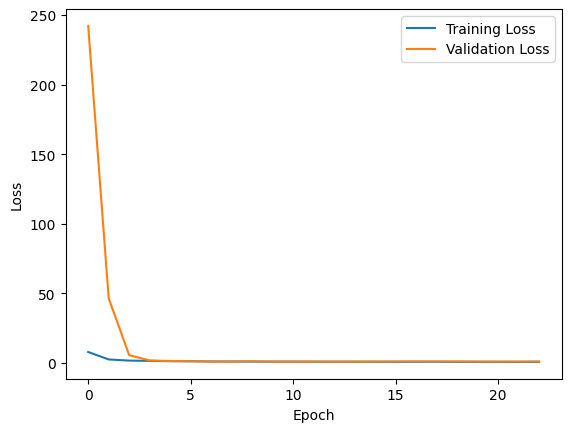

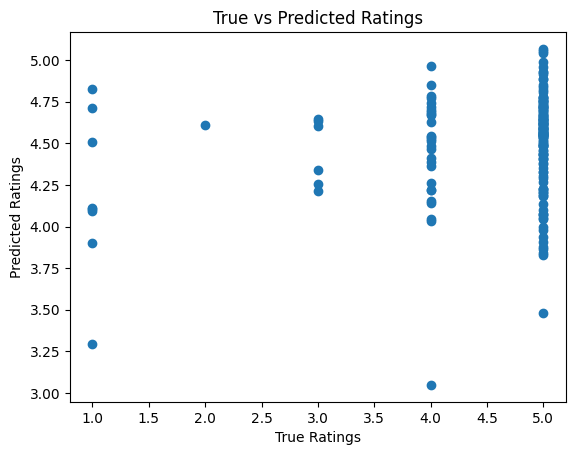

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 7063)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ensemble_model (EnsembleModel)       │ (None, 1)                   │       3,869,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,604,177 (44.27 MB)

 Trainable params: 3,867,397 (14.75 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 7,734,796 (29.51 MB)

In [ ]:
# Define ensemble model
class EnsembleModel(tf.keras.Model):
    def __init__(self, model_collab, model_content, **kwargs):
        super(EnsembleModel, self).__init__(**kwargs)
        self.model_collab = model_collab
        self.model_content = model_content
        self.final_layer = tf.keras.layers.Dense(1, activation='linear')

    def call(self, inputs):
        collab_input = inputs[:, :2]  # user_id and place_id for model_collab
        content_input = inputs[:, 2:]  # feature data for model_content
        collab_output = self.model_collab(collab_input)
        content_output = self.model_content(content_input)
        combined = tf.concat([collab_output, content_output], axis=1)
        output = self.final_layer(combined)
        return output

# Prepare data for hybrid model
train_tfidf = tfidf_matrix[train_df['place_id'].values].toarray()
test_tfidf = tfidf_matrix[test_df['place_id'].values].toarray()
train_data_hybrid = np.concatenate([train_df[['user_id', 'place_id']].values, train_tfidf], axis=1)
test_data_hybrid = np.concatenate([test_df[['user_id', 'place_id']].values, test_tfidf], axis=1)

# Instantiate the collaborative and content models
num_users = len(user_ids)
num_places = len(place_ids)
embedding_size = 50
num_features = train_tfidf_matrix.shape[1]

model_collab = CollabModel(num_users, num_places, embedding_size)
model_content = ContentModel(num_features)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define input layers
input_shape = (train_data.shape[1],)
hybrid_inputs = tf.keras.layers.Input(shape=input_shape)

# Define the ensemble model using the defined input layers
hybrid_outputs = EnsembleModel(model_collab, model_content)(hybrid_inputs)

hybrid_model = tf.keras.Model(inputs=hybrid_inputs, outputs=hybrid_outputs)
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Train the ensemble model
history_hybrid = hybrid_model.fit(
    x=train_data,
    y=train_labels,
    epochs=200,
    batch_size=32,
    verbose=1,
    validation_data=(test_data, test_labels),
    callbacks=[early_stopping]
)

# Evaluate the model
y_pred = hybrid_model.predict(test_data).flatten()
mse = tf.keras.losses.MeanSquaredError()(test_labels, y_pred).numpy()
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)

# Plot the loss
import matplotlib.pyplot as plt

plt.plot(history_hybrid.history['loss'], label='Training Loss')
plt.plot(history_hybrid.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot true vs predicted ratings
plt.scatter(test_labels, y_pred)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs Predicted Ratings')
plt.show()

# Display model summary
hybrid_model.build(input_shape=(None, 2))
hybrid_model.summary()


In [ ]:
# Evaluation
test_pred = hybrid_model.predict(test_data).flatten()
mse = mean_squared_error(test_labels, test_pred)
rmse = np.sqrt(mse)
print("Hybrid MSE:", mse)
print("Hybrid RMSE:", rmse)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Hybrid MSE: 0.8712826297948136
Hybrid RMSE: 0.9334252138199469


# Model Testing

In [ ]:
# Define a function to get restaurant name from place_id
def get_restaurant_name(place_id):
    place_row = merged_df[merged_df['place_id'] == place_id]
    if not place_row.empty:
        return place_row.iloc[0]['place_name']  # Adjust column name if different
    else:
        return "Unknown Place"

# Get recommendations
def get_hybrid_recommendations(user_id, top_n=5):
    user_index = user_id2idx.get(user_id)
    if user_index is None:
        raise ValueError("User ID not found")

    # Get TF-IDF vectors for all places
    place_tfidf = tfidf_matrix.toarray()

    # Prepare input data for the user
    user_input = np.array([[user_index, place_id2idx[place_id]] for place_id in place_ids])
    hybrid_input = np.concatenate([user_input, place_tfidf], axis=1)

    # Get predictions from hybrid model
    predictions = hybrid_model.predict(hybrid_input).flatten()

    # Get top N recommendations
    top_indices = predictions.argsort()[-top_n:][::-1]
    recommended_places = [place_ids[idx] for idx in top_indices]

    return recommended_places

# Test hybrid recommendations with the defined function
user_id = 15  # Replace with the desired user_id
recommended_places = get_hybrid_recommendations(user_id)
print("Recommended places for user_id", user_id, ":")
for i, place_id in enumerate(recommended_places, 1):
    place_name = get_restaurant_name(place_id)
    print(f"{i}. {place_name} (ID: {place_id})")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Recommended places for user_id 15 :
1. Javanegra Gourmet Atelier & Taverna 212 (ID: 48)
2. Jakarta Restaurant (ID: 37)
3. Plataran Dharmawangsa (ID: 9)
4. Central Park Restaurant (ID: 104)
5. Bluegrass Bar & Grill (ID: 6)


# Deploy Model

In [ ]:
saved_model_path = "./my_model.h5"

hybrid_model.save(saved_model_path)

In [ ]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2024-06-15 16:06:19.405629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file
